# **Makerere Fall Armyworm Crop Challenge** 

## Description

   Fall armyworm is a devastating pest in Africa, where it has no natural predators - African farmers say the pest causes average maize losses of 31% annually. Maize is the most widely grown crop in Africa and a staple for around half the continent’s people - over 300 million Africans depend on the crop for food and nutritional security. For smallholder farmers in particular, maize is popular for its wide adaptability, valuable by-products and high yields.

   Because of this reliance on staple crops for food security, Viral pests and diseases like fall armyworm are one of the leading causes of food insecurity and poverty in Africa. Thus there is an urgent need to design early intervention mechanisms to help prevent crop losses for smallholder farmers.

   In this challenge, your objective is to classify if a plant has been affected by a fall armyworm. This is a binary image classification challenge. The solution will be deployed as part of a mobile-based edge application which can be used by smallholder farmers in Uganda and the rest of Africa to carry out field-based diagnosis and intervene before fall armyworm devastates their maize crop for the season.

Link for this Challenge: https://zindi.africa/competitions/makerere-fall-armyworm-crop-challenge/data

You can add the dataset on Kaggle from this url: https://www.kaggle.com/datasets/anaselmasry/makerere-fall-armyworm-crop-challenge

## Importing of Necessary Libraries

In [1]:
from fastai.vision.all import *
from fastai.vision import *
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import os

# No need to reload the notebook if any change in the fastai library
%reload_ext autoreload
%autoreload 2

# Display images in the notebook
%matplotlib inline

## Dataset Loading

In [2]:
path = "../input/makerere-fall-armyworm-crop-challenge/"

In [3]:
train_labels = pd.read_csv(os.path.join(path, "Train.csv"))
train_labels.head(2)

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0


In [4]:
train_fnames = list(map(lambda x : os.path.join(path, "Images/") + x, train_labels['Image_id']))
labels = train_labels['Label']

In [5]:
test = pd.read_csv(os.path.join(path, "Test.csv"))
test_fnames = list(map(lambda x : os.path.join(path, "Images/" + x), test['Image_id']))
test.head(2)

,Image_id
0,id_00exusbkgzw1b.jpg
1,id_03dqinf6w0znv.jpg


In [6]:
sample_sub_v2 = pd.read_csv(os.path.join(path, "SampleSubmission.csv"))
sample_sub_v2.head(2)

,Image_id,Label
0,id_00exusbkgzw1b.jpg,0
1,id_03dqinf6w0znv.jpg,0


## Sample Images
Each image from the dataset has a dimension of 768 by 1024 and a color type of RGB

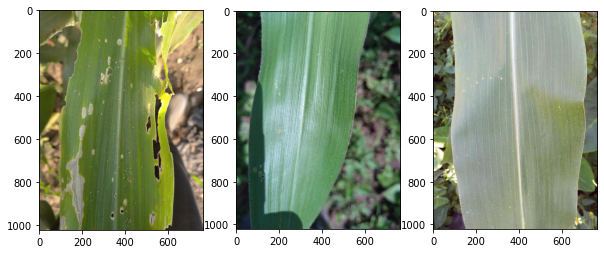

In [7]:
fig, axs = plt.subplots(1,3,figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    img = plt.imread(train_fnames[i])
    ax.imshow(img)
plt.show()

## Transforming and augmenting images

In [8]:
img = PILImage(PILImage.create(img))

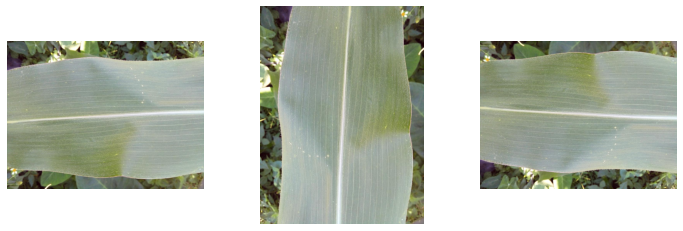

In [9]:
tflip = FlipItem(p=1.)
bbox = TensorBBox(((tensor([[1.,0., 2.,1]]) -1)[None]))
test_eq(tflip(bbox,split_idx=0), tensor([[1.,0., 0.,1]]) -1)

_,axs = plt.subplots(1,3,figsize=(12,4))
for ax in axs.flatten():
    show_image(DihedralItem(p=1.)(img, split_idx=0), ctx=ax)

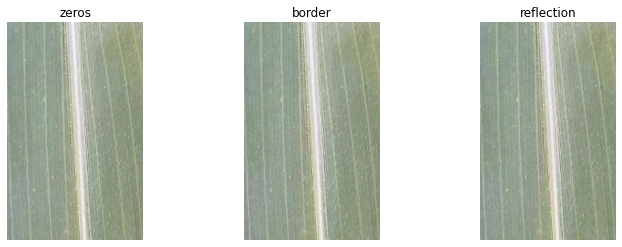

In [10]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,mode in zip(axs.flatten(), [PadMode.Zeros, PadMode.Border, PadMode.Reflection]):
    show_image(img.crop_pad((200,320), pad_mode=mode), ctx=ax, title=mode);

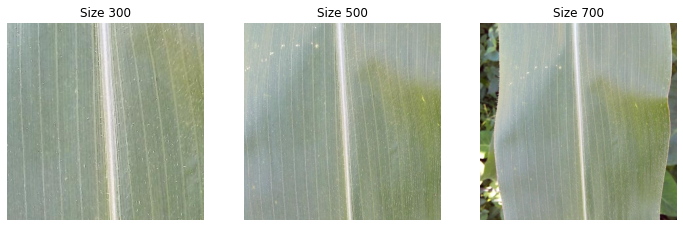

In [11]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,sz in zip(axs.flatten(), [300, 500, 700]):
    show_image(img.crop_pad(sz), ctx=ax, title=f'Size {sz}');

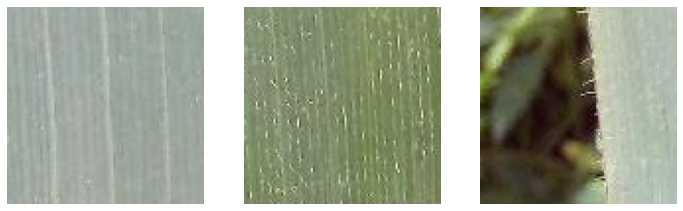

In [12]:
_,axs = plt.subplots(1,3,figsize=(12,4))
f = RandomCrop(100)
for ax in axs: show_image(f(img), ctx=ax);

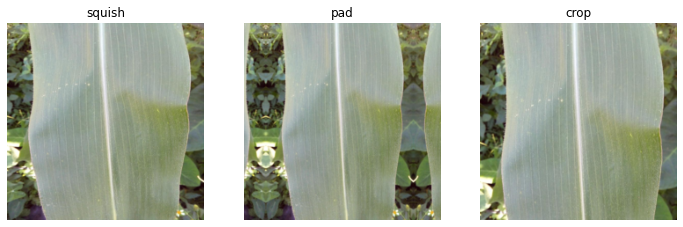

In [13]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(224, method=method)
    show_image(rsz(img, split_idx=0), ctx=ax, title=method);

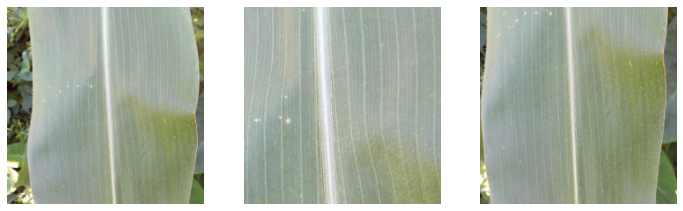

In [14]:
crop = RandomResizedCrop(224)
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax in axs.flatten():
    cropped = crop(img)
    show_image(cropped, ctx=ax);

## Define the image data loader

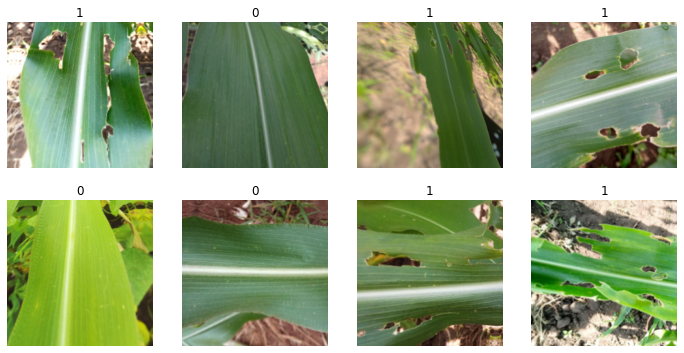

In [15]:
# Define the augmentation pipeline
transforms = aug_transforms(max_rotate=180, max_zoom=1.15, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.)
batch_tfms = [*aug_transforms(size=224, max_warp=.35), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(224, min_scale=0.75, ratio=(1.,1.))
bs=8 # batch_size

# Load the images to the image data loader via the augmentation pipeline and receive augmented images
dls = ImageDataLoaders.from_lists(path, train_fnames, labels,  batch_tfms=batch_tfms,  ds_tfms=transforms,
                                   item_tfms=item_tfms, bs = bs)
dls.show_batch()

## Using the Resnet50 pretrained model

In [16]:
model = resnet50

In [17]:
roc = RocAucBinary()
learn = vision_learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                       ps=0.015, metrics=[accuracy, error_rate, roc]) # ps was used to split the dataset into: Training set(99,5%), Validation set(1,5%).

In [18]:
learn.dls.vocab

[0, 1]

## Fine tune the model

In [19]:
# Find the optimal lr using lr_find()
#learn.lr_find()

In [31]:
# fine tune the model with learning rate and some freeze epochs 
#set the freeze_epochs as 1 i.e. number of epochs for which the fine-tuning of the model is done. 
#Then we fit the model for 5 epochs
learn.fine_tune(5, base_lr=3e-3, freeze_epochs=1) 

epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,time
0,0.126415,0.127317,0.972136,0.027864,0.988996,05:23


epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,time
0,0.163222,0.061109,0.987616,0.012384,0.997124,06:45
1,0.147203,0.033473,0.990712,0.009288,0.999540,06:44
2,0.099473,0.038092,0.987616,0.012384,0.999885,06:41
3,0.109880,0.024457,0.993808,0.006192,0.999847,06:38
4,0.117352,0.011896,0.996904,0.003096,1.000000,06:48


## Final Evaluation

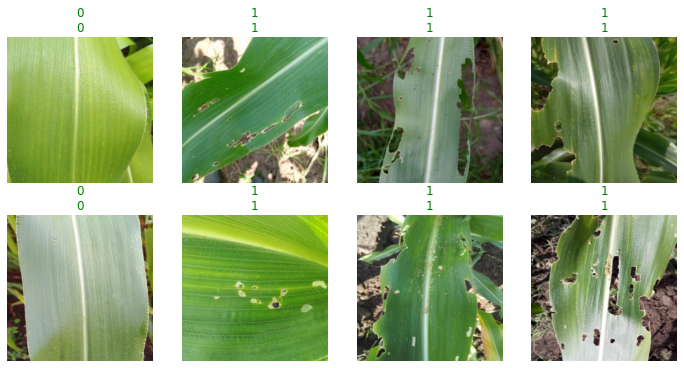

In [32]:
learn.show_results(ds_idx=1, dl=None, max_n=9, shuffle=True)

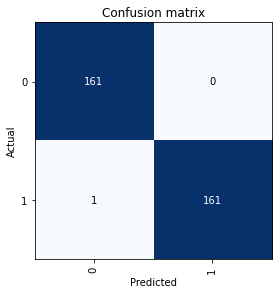

In [33]:
# create the interepreation object from our model
interep = ClassificationInterpretation.from_learner(learn)

# Plot the confusion matrix
interep.plot_confusion_matrix()

## Show prediction tensors of a training image

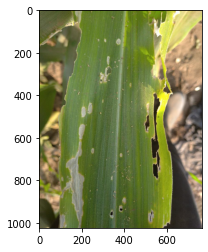

In [34]:
image = plt.imread(train_fnames[0])
plt.imshow(image)

In [35]:
learn.predict(train_fnames[0]) # Geting the predicted Label for the image and then the probabilities

('1', TensorBase(1), TensorBase([3.9286e-06, 1.0000e+00]))

## Getting the predicted probabilities

In [36]:
preds = learn.get_preds(dl=dls.test_dl(test_fnames)) 

In [37]:
preds[0][0], np.argsort(preds[0])[0] # We have probs and then labels

(TensorBase([0.9883, 0.0117]), TensorBase([1, 0]))

In [38]:
#sample_sub_v2['Label'] = np.argsort(preds[0])[:,1] # If you want to get the labels (0 and 1)
sample_sub_v2['Label'] = preds[0][:,1] # To get the predicted probs
sample_sub_v2['Image_id'] = [''.join(x.split('/')[-1]) for x in test_fnames]
sample_sub_v2 = sample_sub_v2[['Image_id', 'Label']]
sample_sub_v2.to_csv('sub_auc.csv', index=False) # save and submit
sample_sub_v2.head()

,Image_id,Label
0,id_00exusbkgzw1b.jpg,0.011743
1,id_03dqinf6w0znv.jpg,0.000084
2,id_046yl0cxn3ybz.jpg,0.999999
3,id_04athdtx2abyg.jpg,0.000180
4,id_062aauf9e9jk0.jpg,0.005689
